In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
import numpy as np

from warnings import filterwarnings
filterwarnings("ignore")


/home/mustafa/miniconda3/envs/t2/lib/python3.13/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
cali_df_temp = fetch_california_housing(as_frame=True)

cali_housing_samples : pd.DataFrame = cali_df_temp['data']
cali_housing_targets : pd.DataFrame = cali_df_temp['target']

---

<h3 align='center'> <font color='cyan'> Data description </font></h3>

In [3]:
print(cali_df_temp.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [4]:
cali_df : pd.DataFrame = cali_df_temp.frame
cali_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


<br><br>
* We see that:
1. the dataset contains 20,640 samples and 8 features;
2. all features are numerical features encoded as floating number;
3. there is no missing values.
<br><br><br><br>

Let's look at the distribution of each feature and the target variable

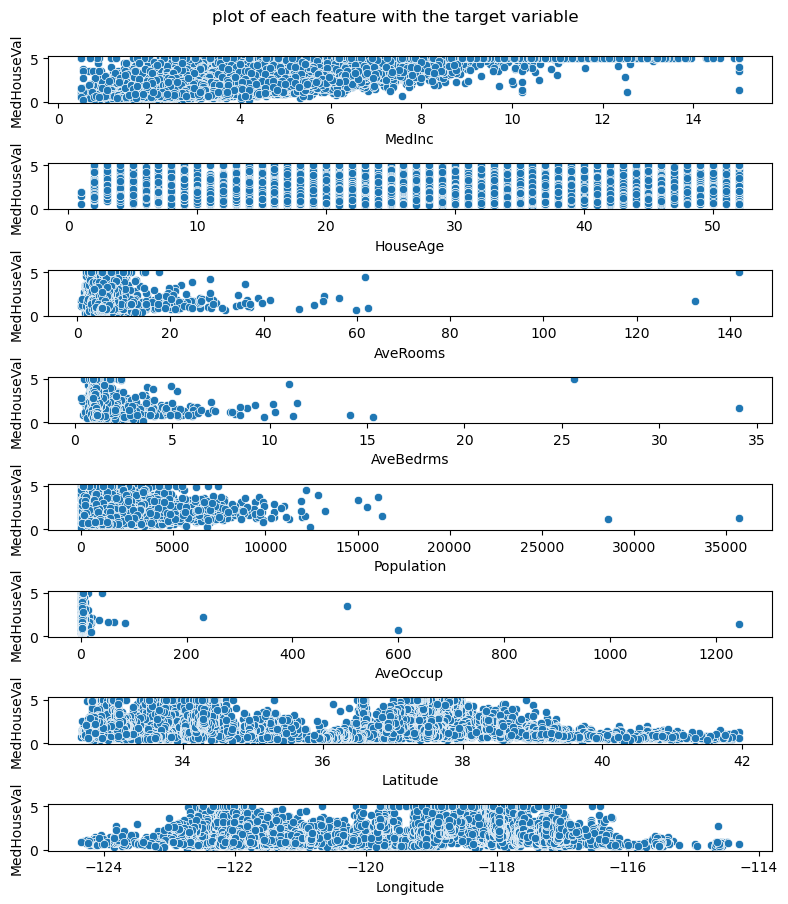

In [5]:
feature_names : list[str] = cali_housing_samples.columns

figure, axes = plt.subplots(nrows=len(feature_names), ncols=1)
figure.set_size_inches(8, 9)

for index, column_name in enumerate(feature_names):
    sns.scatterplot(x=cali_df[column_name], y=cali_housing_targets, ax=axes[index])

figure.suptitle('plot of each feature with the target variable', y=1)
figure.tight_layout()

Not much discernible relationship between any feature and the target variable

---
<h1 align='center'> <font color='cyan'>Outliers</font></h1>

* Now, let's check if there's any outliers in this dataset using boxplots of the features(columns) and the target(MedHouseVal)

Text(0.5, 0.98, "Boxplot of each feature and the target to see if there's any outliers")

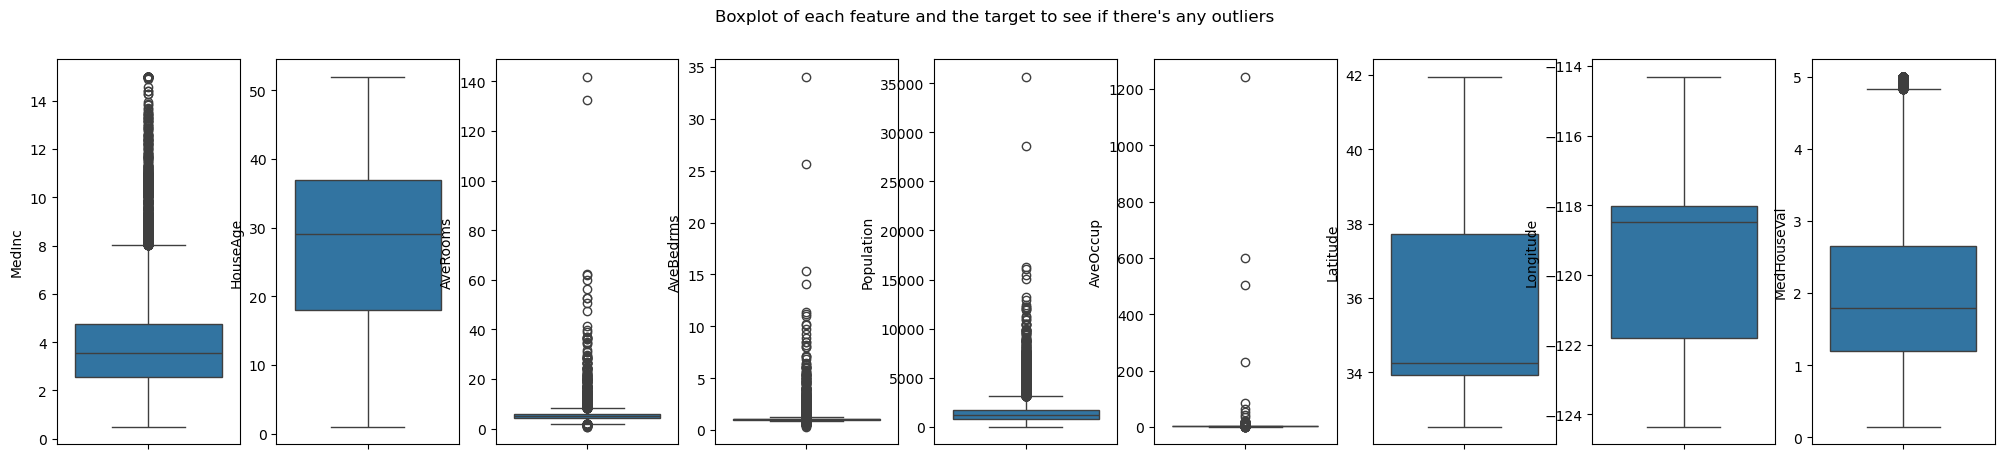

In [6]:
number_of_columns = cali_df.shape[1]
fig, ax = plt.subplots(nrows=1, ncols=number_of_columns, figsize=(25, 5))


for index, column in zip(np.arange(number_of_columns), cali_df.columns):
    sns.boxplot(cali_df[column], ax=ax[index])

fig.suptitle('Boxplot of each feature and the target to see if there\'s any outliers')

* The following features have a large number of outliers
    * MedInc
    * AveRooms
    * AveBedrooms
    * Population
    * AveOccup

* I don't think the target variable have significant outliers.\
    The boxplot shows that we have a threshold-effect for high-valued houses: all houses with a price above 5 are given the value 5

* Focusing on the average rooms, average bedrooms, average occupation, and population,\
the range of the data is large with unnoticeable bin for the largest values.
* It means that there are very high values (maybe they could be considered as outliers?).
* We can see this specificity looking at the statistics for these features:

In [7]:
features_of_interest = ["MedInc", "AveRooms", "AveBedrms", "AveOccup", "Population"]
cali_df[features_of_interest].describe()

,MedInc,AveRooms,AveBedrms,AveOccup,Population
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,5.429000,1.096675,3.070655,1425.476744
std,1.899822,2.474173,0.473911,10.386050,1132.462122
min,0.499900,0.846154,0.333333,0.692308,3.000000
25%,2.563400,4.440716,1.006079,2.429741,787.000000
50%,3.534800,5.229129,1.048780,2.818116,1166.000000
75%,4.743250,6.052381,1.099526,3.282261,1725.000000
max,15.000100,141.909091,34.066667,1243.333333,35682.000000


* Here we see that these features' max values are quite higher than the 3rd quantily (75% or 75th percentile)\
Especially the AveOccup (average number of household members) and population (block group population)
<br><br>

* Here we should be imputing (replacing) the data points that are significantly higher than the third quantile or significantly lower than the first quantile
* I prefer imputing with the median of the column, but it can also be done with the mean of the column.\
or we can remove these rows all together.<br><br>
* I don't like the idea of removing rows just because they are outliers
* But I don't know how to replace the outliers with another value (for now), so I will be removing the rows

In [8]:
features_of_interest = ["MedInc", "AveRooms", "AveBedrms", "AveOccup", "Population"]
outlier_mask = pd.Series([True] * len(cali_df), index=cali_df.index)

# Iterate through each column to identify outliers
for col in features_of_interest:
    Q1 = cali_df[col].quantile(0.25)
    Q3 = cali_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Update the mask to exclude rows with outliers in the current column
    outlier_mask = outlier_mask & (cali_df[col] >= lower_bound) & (cali_df[col] <= upper_bound)

# Filter the DataFrame to remove rows containing outliers
df_cleaned = cali_df[outlier_mask]

# how many rows did we lose
number_of_rows_lost = cali_df.shape[0] - df_cleaned.shape[0]
print(f'Number of lost rows: {number_of_rows_lost} row')

# what is percentage of lost rows
percentage_lost_rows = number_of_rows_lost / cali_df.shape[0] * 100
print(f'percentage of lost rows: {percentage_lost_rows:.0f} %')


Number of lost rows: 3798 row
percentage of lost rows: 18 %


Text(0.5, 0.98, 'Boxplot of each feature and the target after outliers have been removed')

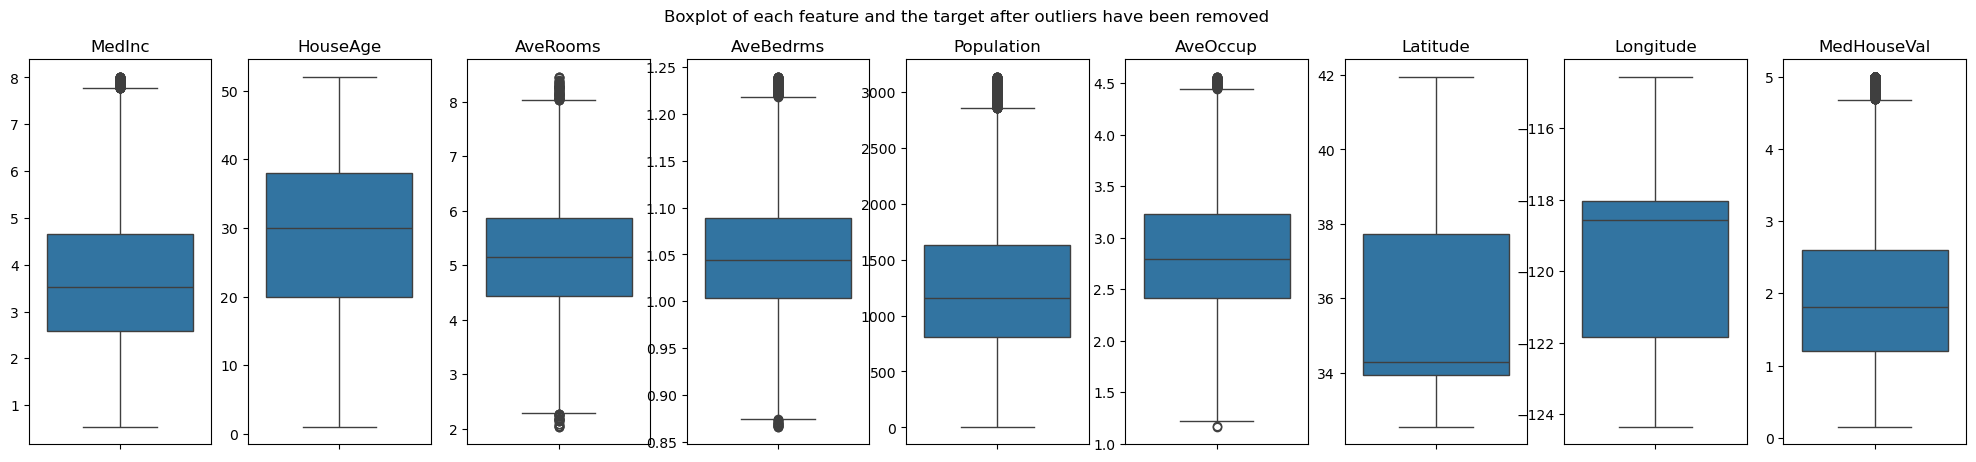

In [9]:
number_of_columns = df_cleaned.shape[1]
fig, ax = plt.subplots(nrows=1, ncols=number_of_columns, figsize=(25, 5))


for index, column in enumerate(df_cleaned.columns):
    sns.boxplot(df_cleaned[column], ax=ax[index])
    ax[index].set_title(df_cleaned.columns[index])  # title of the boxplot variable
    ax[index].set_ylabel(None)  # remove the vertical y-axis label

fig.suptitle('Boxplot of each feature and the target after outliers have been removed')

* Comparing this figure with the boxplot above, we see that the outliers have been removed
* The circles at the bottom and top whiskers are all the values at exactly the 25th percentile and 75th perecentile

In [10]:
cali_housing_samples = df_cleaned.drop(['MedHouseVal'], axis=1)
cali_housing_targets = df_cleaned['MedHouseVal']

---
<h3 align='center'> <font color='cyan'>Correlation</font></h3>

* Let's check on the correlation between the features(columns) in this data

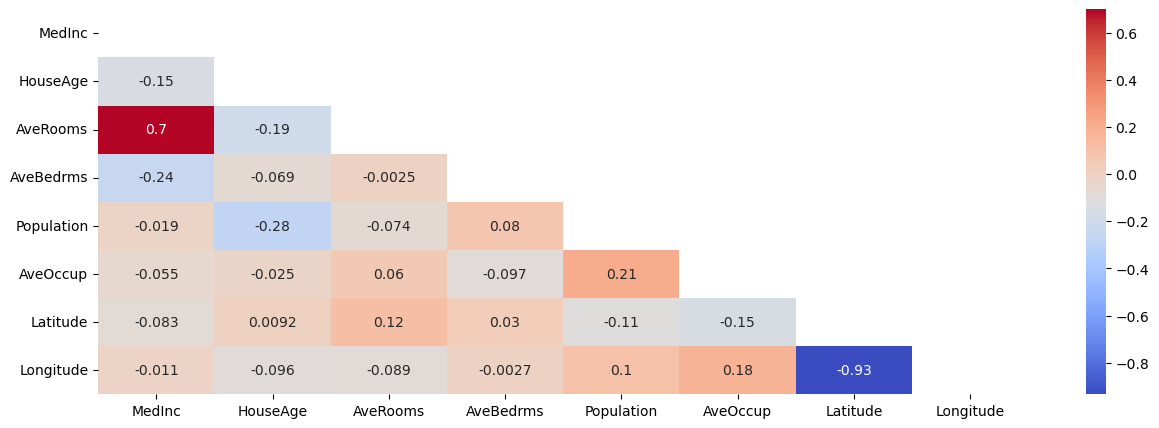

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))
correlation_matrix = cali_housing_samples.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=np.triu(np.ones_like(correlation_matrix.corr())));

* We see that:
    * (Incorrect; was true before removing outliers ) ~~average number of rooms (AveRooms) and average number of bedrooms (AveBedrms) are highly correlated (0.85)~~
    * latitude and longtitude are also highly correlated (-0.92)
    * other features are not highly correlated. In fact, they are very weakly correlated.\
    Except for median income (MedInc) and average number of rooms (AveRooms), but the correlation is not that strong.
<br><br>

* This is in fact, not a good sign for our model of choice: linear regression.
- One of the assumptions linear regression makes about the data is that the independent variables (features) are not highly correlated (multicolinearity)
- But I will still start with linear regression, because it's the one I think it provides a good basis of prediction, scoring, and error functions.
- If the results are not satisfactory, which I expect them to be, then perhaps I can move on to other algorithms like Ridge or Lasso regression. 

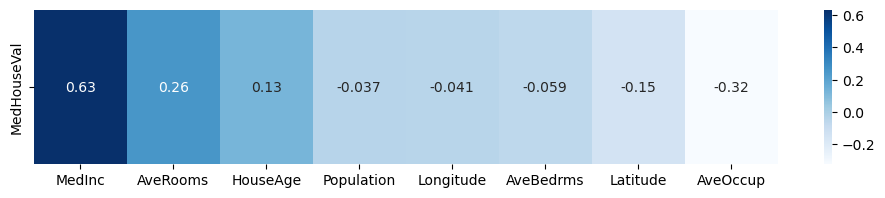

In [12]:
fig, ax = plt.subplots(figsize=(12, 2))

correlation_with_target : pd.Series = df_cleaned.corr()['MedHouseVal']  # correlation of the features with only 'MedHouseVal'; the target
df = pd.DataFrame(correlation_with_target)  # turn into a dataframe
df.drop('MedHouseVal', inplace=True, axis=0)  # it's the correlation of MedHouseVal with MedHouseVal, so it's a known 1

sns.heatmap(df.T.sort_values(by='MedHouseVal', ascending=False, axis=1), cmap='Blues', annot=True);

---
<h3 align='center'> <font color='cyan'> Goal  </font> </h3>

- The goal in using this dataset is to try and predict the median house value (`MedHouseVal` column) using the other columns as features (predictors)
- So the dependent variable is `MedHouseVal` and the other variables are the independent variables.


---
<h3 align='center'> <font color='cyan'> Linear Regression  </font> </h3>

* Linear Regression assumes the following:
<br><br>
    1. Linearity:
        - Linear regression assumes a linear relationship between input and output variables.\
        If the relationship is not linear, another type of regression, like polynomial or logarithmic, might be more suitable.
        - How to check: Use scatter plots to visually assess the relationship between variables.

    2. No Multicollinearity:
        - The features they should not highly correlated with each other.
        - How to check: Calculate correlation coefficients between independent variables or use variance inflation factor (VIF).
    
    3. Normality of Residuals:
        - The error terms should be approximately normally distributed. 
        - How to check: Use histograms, Q-Q plots, or formal normality tests (like Kolmogorov-Smirnov) to assess the distribution of residuals.
    
    4. Independence of Residuals:
        - The error terms (residuals) should be independent of each other. This means that the error for one observation should not be related to the error for any other observation.
        - How to check: Examine a scatter plot of residuals against predicted values. A random scatter indicates independence. 
    
    5. Homoscedasticity (constant variance of residuals)):
        - The variance of the error terms should be constant across all levels of the independent variables. 
        - How to check: Look for a consistent spread of residuals in a scatter plot of residuals versus predicted values. A "fan" or "megaphone" shape suggests heteroscedasticity.

---
<h3 align='center'> <font color='cyan'> Learning  </font> </h3>

* We will split the data into a training set and a testing set (80% training set, and 20% testing set)
* The training of the model will be on the training set
* The testing of the model will be on the testing set
* We'll use Linear Regression

In [23]:
# splitting the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(cali_housing_samples, cali_housing_targets, test_size=0.2, random_state=100, shuffle=True)

y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

print('Training samples has:', X_train.shape[0], 'rows and ', X_train.shape[1], 'columns')
print('Training target has: ',  y_train.shape[0], 'rows and', y_train.shape[1], 'columns')
print('Testing samples has: ', X_test.shape[0], 'rows and ', X_test.shape[1], 'columns')
print('Testing target has: ',  y_test.shape[0], 'rows and', y_test.shape[1], 'columns')

Training samples has: 13473 rows and  8 columns
Training target has:  13473 rows and 1 columns
Testing samples has:  3369 rows and  8 columns
Testing target has:  3369 rows and 1 columns


Traing the model on the training set and evaluating it on the testing set produces the following weights and intercept:

In [ ]:
lr_1 = LinearRegression().fit(X_train, y_train)

print('Weights of each column are:')
for column, weight  in zip(X_train.columns, lr_1.coef_[0]):
    print(f'\t{column}:  {weight:.8f}')

print(f'\nintercept: {lr_1.intercept_[0]:.2f}')

predictions_original_samples = lr_1.predict(X_test)

# coeff_df = pd.DataFrame(index=X_train.columns, data={'Coeffs': lr_1.coef_.flatten()}).sort_values(by='Coeffs', ascending=False)
# coeff_df

Weights of each column are:
	MedInc:  0.50322764
	HouseAge:  0.01361640
	AveRooms:  -0.15453692
	AveBedrms:  1.79827785
	Population:  0.00007468
	AveOccup:  -0.44093887
	Latitude:  -0.39612395
	Longitude:  -0.39121091

intercept: -32.85


We see that the weights are very small indicating that the features are not meaningful in predicted the target variable

---
<h1 align='center'><font color='cyan'> Score </font> </h1>

* R-squared:
    * R-squared measures the proportion of variance for a dependent variable that is explained by the independent variable(s) in a regression model.\
    
    * It can also be thought of as a measure of goodness of fit, or how well data fits the regression model.\
        The R-squared of a regression model is positive if the model’s prediction is better than a prediction, which is just the mean of the already available ‘y’ values.\
        Otherwise, the R-squared value is closer to 0..
    
    * An R-squared value ranges from 0 to 1, where 1 indicates a perfect model fit and 0 indicates no model fit.

In [ ]:
r_squared = r2_score(y_true=y_test, y_pred=predictions_original_samples)
mse = mean_squared_error(y_true=y_test, y_pred=predictions_original_samples)
rmse = root_mean_squared_error(y_true = y_test, y_pred = predictions_original_samples)
mae = mean_absolute_error(y_true = y_test, y_pred = predictions_original_samples)

print(f'R2 score: {r_squared:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean square error: {rmse:.2f}')
print(f'Mean Absolute error: {mae:.2f}')

R2 score: 0.64
Mean squared error: 0.43
Root mean square error: 0.65
Mean Absolute error: 0.49


* The R2 score is interesting to me.\
I thought it would be lower, since I don't trust the model due to insignificant weights\
(I'm not sure if my thinking that insignificant weights should lead to lower R2 score is accurate)

* An R2 score of 0.6 says that the model explains 60% of the variance in the data\
    I don't think this is good enough 

* I think that this data does is not good for predicting the median house value\
the reason i think this is because none of the feature show any correlation with the target (median house value)\
the weights above show that none of the weights is high enough to signal any relation between the features and target

* Maybe it's because of the outliers in the data. specifically, these columns
    * MedInc
    * AveRooms
    * AveBedrooms
    * Population
    * AveOccup

* Next, I will normalize the data and apply the model again on the normalized data, and see if the model improves

---
# <h1 align='center'><font color='cyan'> Scaling </font> </h1>



* I'm going to try normalizing the data, and see if the model is going to get any better

* Here, I'm going to normalize the data using <b>StandardScaler</b>
    * StandardScaler subtract each data point from the mean of the column(feature) and divide by the standard deviation\
      This translates into a features with <b>mean = 0</b> and <b>standard deviation = 1</b>
<br><br>

* <b>Note</b>: It's better to split the data before applying normalizing it.\
Otherwise, the normalization will use the mean and standard deviation of the entire dataset,\
instead of just the mean and standard deviation of the segment of data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(cali_housing_samples, cali_housing_targets, test_size=0.2, random_state=100, shuffle=True)

standard_scaler_on_features = StandardScaler()  # separate scaler for the features of testing, and training sets

X_train_scaled = standard_scaler_on_features.fit_transform(X_train)
X_test_scaled = standard_scaler_on_features.transform(X_test)

standard_scaler_on_targets = StandardScaler() # separate scaler for the targets of testing, and training sets
y_train_scaled = standard_scaler_on_targets.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = standard_scaler_on_targets.transform(y_test.values.reshape(-1, 1))

print(X_train_scaled.shape)
print(y_train_scaled.shape)
print(X_test_scaled.shape)
print(y_test_scaled.shape)

(13473, 8)
(13473, 1)
(3369, 8)
(3369, 1)


~~Let's make sure the outliers are gone using boxplots~~

Scaling the data is not the correct to remove outliers.
The outliers remain, just in different scale and numerical form.

Text(0.5, 1.0, 'Incorrect Information')

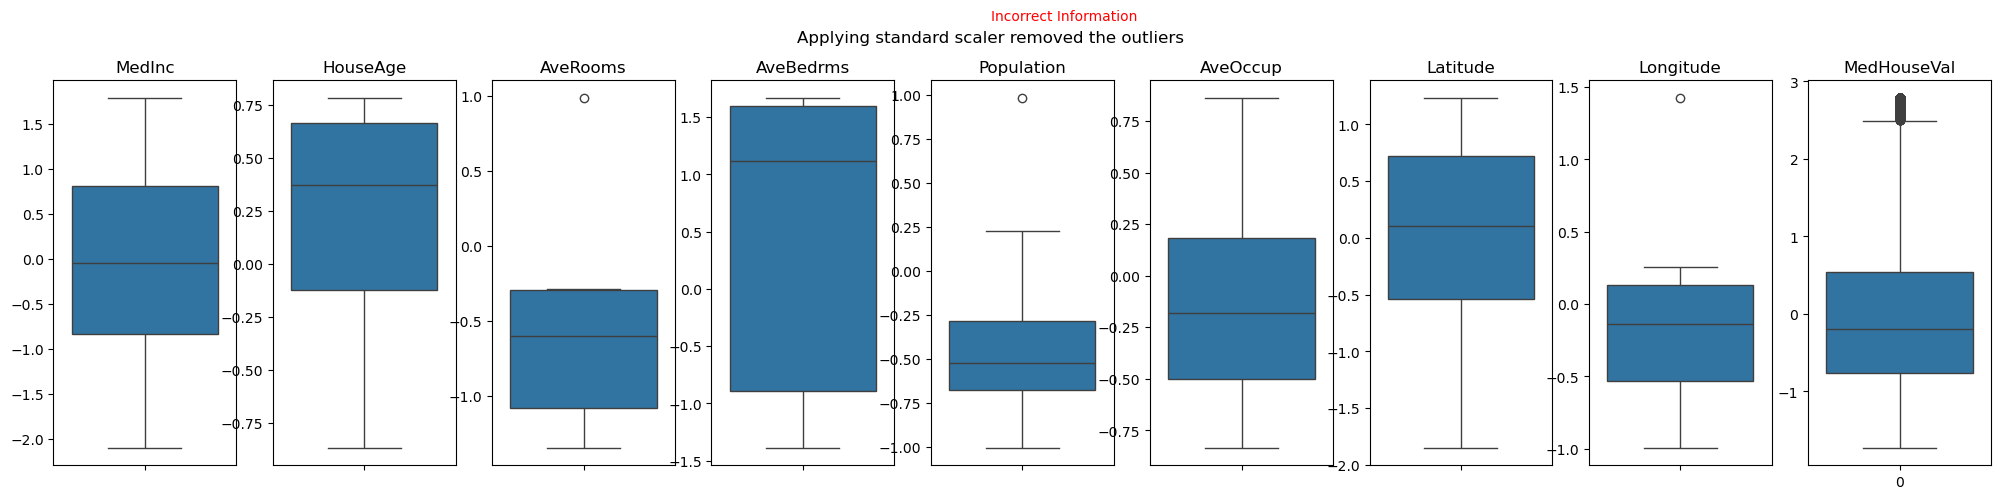

In [37]:
number_of_columns = X_train_scaled.shape[1]
fig, ax = plt.subplots(nrows=1, ncols=number_of_columns + 1, figsize=(25, 5))


for index in np.arange(number_of_columns):
    sns.boxplot(X_train_scaled[index], ax=ax[index])
    ax[index].set_title(X_train.columns[index])

sns.boxplot(y_train_scaled, ax=ax[-1])
ax[-1].set_title('MedHouseVal')
fig.suptitle('Applying standard scaler removed the outliers')
fig.text(0.5, 1.0, 'Incorrect Information', color='red')

In [25]:
lr_2 = LinearRegression().fit(X_train_scaled, y_train_scaled)
predictions_lr_scaled_samples = lr_2.predict(X_test_scaled)

scaled_coefficients = lr_2.coef_[0]  # weights of the features in the units and space of the scaled model
scaled_intercept = lr_2.intercept_[0]  # intercept in the scaled space

# rescale the weights back into the original feature space of the dataset
coefficients_in_original_scale = scaled_coefficients * (standard_scaler_on_targets.scale_ / standard_scaler_on_features.scale_)
# rescale the intercept back into the original feature space of the dataset
intercept_in_original_scale = standard_scaler_on_targets.mean_[0] - np.sum(coefficients_in_original_scale * standard_scaler_on_features.mean_)

print('Weights of each column after scaling are:')
for column, weight  in zip(X_train.columns, lr_2.coef_[0]):
    print(f'\t{column}:  {weight:.2f}')
print(f'\nIntercept after scaling is: {scaled_intercept:.2f}')

print('\n\nWeights of each column in the original scale are:')
for column, weight  in zip(X_train.columns, coefficients_in_original_scale):
    print(f'\t{column}:  {weight:.2f}')

print(f'\nintercept in the original scale is: {intercept_in_original_scale:.20f}')

Weights of each column after scaling are:
	MedInc:  0.70
	HouseAge:  0.16
	AveRooms:  -0.15
	AveBedrms:  0.11
	Population:  0.04
	AveOccup:  -0.26
	Latitude:  -0.79
	Longitude:  -0.73

Intercept after scaling is: 0.00


Weights of each column in the original scale are:
	MedInc:  0.50
	HouseAge:  0.01
	AveRooms:  -0.15
	AveBedrms:  1.80
	Population:  0.00
	AveOccup:  -0.44
	Latitude:  -0.40
	Longitude:  -0.39

intercept in the original scale is: -32.84873073126028941715


- I didn't know this at the time. but this `Normalization` section is not useful in terms of interpreting the coefficients of the features.
- I also don't think it's useful in terms of reducing the mean squared error.
* In summary, scaling the dataset is not useful for interpreting the model or reducing the mean squared error. This is for unregularized linear regression<br>
It is useful for for regularized linear regression like Lasso and Ridge models.<br>
It is also useful for optimization, especially optimization methods that use iterative algorithms like Gradient Descent. These optimization methods converge faster and more reliably when the features are on the same scale<br>

- I could have removed this entire section for presentation sake, but I want to keep my mistake for learning purposes, in case I review this project in the future.

---
# <h1 align='center'><font color='cyan'> Scoring </font> </h1>

In [31]:
# Inverse transform both y_test and predictions
y_test_unscaled = standard_scaler_on_targets.inverse_transform(y_test_scaled)
predictions_unscaled = standard_scaler_on_targets.inverse_transform(predictions_lr_scaled_samples)

r2_score_2 = r2_score(y_true=y_test_unscaled, y_pred=predictions_unscaled)
mse_2 = mean_squared_error(y_true=y_test_unscaled, y_pred=predictions_unscaled)
rmse = root_mean_squared_error(y_true = y_test_unscaled, y_pred = predictions_unscaled)
mae = mean_absolute_error(y_true = y_test_unscaled, y_pred = predictions_unscaled)

print(f'R2 score: {r2_score_2:.2f}')
print(f'Mean squared error: {mse_2:.2f}')
print(f'Root mean square error: {rmse:.2f}')
print(f'Mean Absolute error: {mae:.2f}')

R2 score: 0.64
Mean squared error: 0.43
Root mean square error: 0.65
Mean Absolute error: 0.49


Before scaling:
- R2 score: 0.64
- Mean squared error: 0.43
- Root mean square error: 0.65
- Mean Absolute error: 0.49

* R_Squared value doesn't change with normalization, since normalization is a linear transformation (subtract and divide)

# <h1 align='center'><font color='red'> Important point </font> </h1>

* Error metrics should <span style="color: red;">NOT</span> be applied to the scaled data.
  * In other words, the `y_true` and `y_pred` parameters of r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error should be unscaled.
* Also, the coefficients of the features are not useful and shouldn't be used.
  * This is because they are in the scaled units (space), not in the feature space that is from real life
* Scaling of the targets is not necassary and not recommended in my understanding.
    * fitting the model becomes:  .fit(X_train_scaled, y_train)
    * predicting becomes: .predict(X_test)
    * and R2 is r2_score(y_test, predictions)
    * same for all other error metrics


#### Why scale features for linear regression if error metrics end up similar and coefficients become harder to interpret?
1. Scaling improves numerical stability and optimization
    * Linear regression uses algorithms like gradient descent or direct matrix inversion.
    * When features have very different scales, the algorithm can be unstable or slow to converge.
    * Scaling speeds up training and reduces rounding errors, especially with many or very different-scale features.

2. Regularization relies on scaling
    * If you apply regularized linear models (Lasso, Ridge), scaling is required.
    * Without scaling, regularization penalizes coefficients unevenly (large-scale features get smaller coefficients just due to scale, not importance).
    * So scaling ensures regularization behaves properly.

3. Coefficients in scaled models are less interpretable directly
    * True, coefficients correspond to scaled features, so interpreting raw coefficient values is tricky.
    * But you can convert scaled coefficients back to the original scale (like you did), recovering interpretability.
    * Without scaling, coefficients are interpretable but training might be less stable or slower.

4. Error metrics end up similar because they’re computed on the original scale
    * Scaling is a training convenience, not a change in the model’s underlying relationship.
    * When you invert predictions back to original scale, error metrics reflect real-world units, so they match unscaled training results.

#### What about when Regularized models like Lasso and Ridge?
* Lasso and Ridge require scaling to perform properly, so you must rescale the data back to the feature space
1. Scale the X data (X_train and X_test)
2. Do <span style="color: red;">NOT</span> scale the y_train and y_test
3. Fit the model to the data
4. Predict the model on `y_test`
5. Use error metrics on `y_test` and `predictions`
6. Apply the following equation, to get the correct coefficients (in feature space)
```
# lr.coef_ shape: (n_features,) or (1, n_features)
# scaler_X.scale_ contains std dev of each feature used in scaling

coefficients_original = lr.coef_ / standard_scaler_on_features.scale_
intercept_original = lr.intercept_ - np.sum(coefficients_original * standard_scaler_on_features.mean_)
```

---
<h3 align='center'><font color='cyan'> Residuals plot </font> </h3>

* The residuals plot should be normally distributed

Residuals before scaling mean: -0.01, Standard deviation: 0.65
Residuals after scaling mean: 2.01, Standard deviation: 0.66
0.42543669698610753


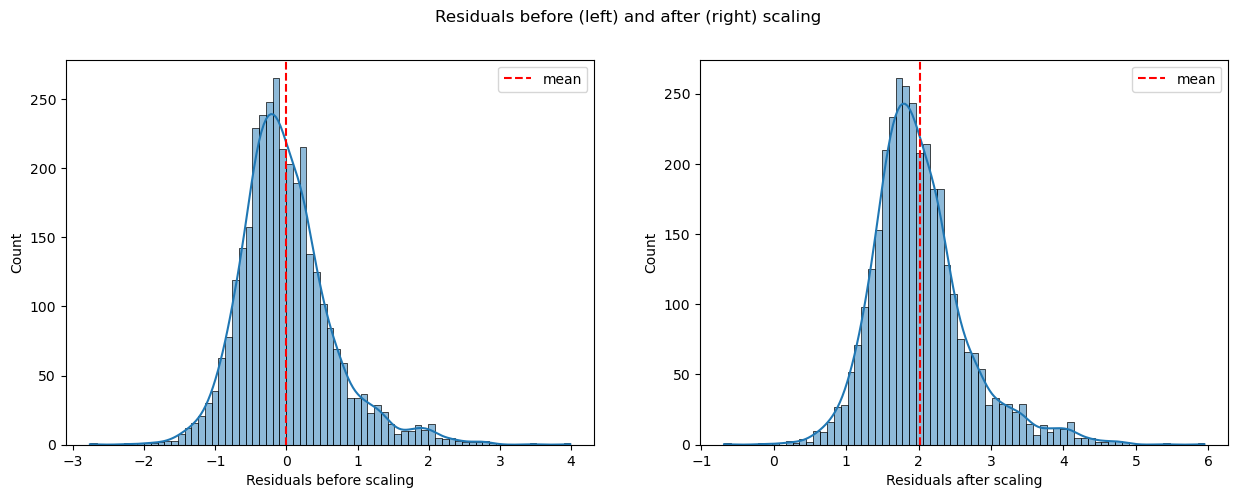

In [21]:
residuals_1 = y_test.values.reshape(-1, 1) - predictions_original_samples
residuals_2 = y_test.values.reshape(-1, 1) - predictions_lr_scaled_samples

print(f'Residuals before scaling mean: {residuals_1.mean():.2f}, Standard deviation: {residuals_1.std():.2f}')
print(f'Residuals after scaling mean: {residuals_2.mean():.2f}, Standard deviation: {residuals_2.std():.2f}')


figure, axes = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(15, 5)
figure.suptitle('Residuals before (left) and after (right) scaling')

sns.histplot(residuals_1, kde=True, ax=axes[0])
axes[0].axvline(x=residuals_1.mean(), color='red', linestyle='dashed', label='mean')
axes[0].set_xlabel('Residuals before scaling')
axes[0].legend()

sns.histplot(residuals_2, kde=True, ax=axes[1])
axes[1].axvline(x=residuals_2.mean(), color='red', linestyle='dashed', label='mean')
axes[1].set_xlabel('Residuals after scaling')
axes[1].legend()

print(residuals_1.var())

* The residuals are indeed normally distributed

---
<h3 align='center'><font color='cyan'> Homoscedasticity (constant variance of residuals) </font> </h3>

- If the plot shows a random scatter of points with roughly equal variance across all predicted values, it suggests homoscedasticity.
- Conversely, a funnel shape or other patterns in the plot indicate heteroscedasticity (non-constant variance), where the variance of residuals changes with the predicted values.
<br><br>
- <b> Homoscedastic Plot:</b>
    - If the plot shows a random scatter of points with no discernible pattern and the spread of residuals is roughly the same across the range of predicted values, it indicates homoscedasticity.
- <b> Heteroscedastic Plot:</b>
    - If the plot shows a funnel shape, a cone shape, or a band that widens or narrows, it suggests heteroscedasticity. This indicates that the variance of residuals is not constant across the range of predicted values. 

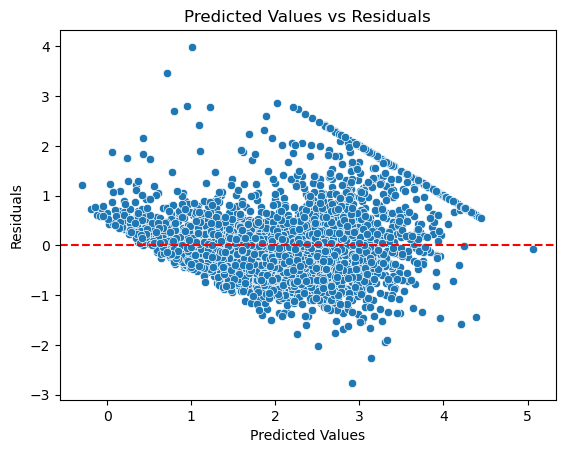

In [22]:
sns.scatterplot(x=predictions_original_samples.flatten(), y=residuals_1.flatten())
plt.axhline(y=0, color='red', linestyle='dashed')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Predicted Values vs Residuals');

---
---
---

* What feature importance means:
  * Each value shows the relative contribution of that feature in reducing prediction error (impurity) across all splits in the tree.
  * Values sum to 1.
  * Higher values mean the model relies more on that feature to make decisions.



| Feature    | Importance | Interpretation                                                                              |
| ---------- | ---------- | ------------------------------------------------------------------------------------------- |
| MedInc     | 0.51       | **Dominant feature** — the model relies heavily on median income to predict housing prices. |
| AveOccup   | 0.18       | Second most important — average occupancy also strongly influences predictions.             |
| Longitude  | 0.12       | Location along longitude is significant.                                                    |
| Latitude   | 0.10       | Location along latitude also matters, but slightly less than longitude.                     |
| HouseAge   | 0.06       | Moderate importance — age of houses has some effect.                                        |
| AveRooms   | 0.03       | Low impact — average rooms per household is less influential.                               |
| AveBedrms  | 0.01       | Very low importance.                                                                        |
| Population | 0.00       | Negligible impact in this model.                                                            |
